In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from matplotlib.colors import SymLogNorm, Normalize

In [118]:
img = fits.open('/home/aalvarez/Work/Data/sim11/sim11_r_01.fits')[0]
img = img.data * img.header['FLXSCALE']

In [119]:
cell_size = 64

In [120]:
def get_cell(x, y):
    return img[y*cell_size:y*cell_size+cell_size,x*cell_size:x*cell_size+cell_size]

In [135]:
cell = get_cell(3, 17)

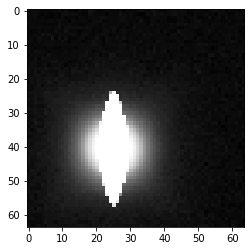

In [141]:
plt.figure()
plt.imshow(cell, cmap='Greys_r', norm=SymLogNorm(1000))

In [149]:
def hist_stats(hist_mid, hist_val):
    lowsum = highsum = 0.
    ilow = 0
    ihigh = len(hist_val) - 1
    sum_total = 0.
    sum_count = 0.
    std = 0.
    for val, count in zip(hist_mid, hist_val):
        if lowsum < highsum:
            lowsum += hist_val[ilow]
            ilow += 1
        else:
            highsum += hist_val[ihigh]
            ihigh -= 1
        sum_total += val * count
        sum_count += count
        std += count * val * val
        
    i = np.max([hist_val[ilow], hist_val[ihigh]])
    median = hist_mid[ihigh] + 0.5 + (highsum - lowsum) / (2 * i)
    mean = sum_total / sum_count
    std = np.sqrt(std / sum_count - mean ** 2)    
    return median, mean, std

In [150]:
class BackgroundHistogram(object):
    
    def __compute_binning(self, ndata, nsigma, minpixel):
        nbins = (ndata * np.sqrt(2/np.pi) * nsigma / minpixel) + 1
        return np.min([nbins, 4096]).astype(np.int)
    
    def __init__(self, data, kappa=2, nsigma=5, minpixel=4):
        """
        Constructor
        """
        # Compute mean and standard deviation over the original data
        mean, std = np.mean(data), np.std(data)
        # Compute first cut, +- std * kappa
        lcut, hcut = mean - std * kappa, mean + std * kappa
        print(mean, std, kappa)
        print(lcut, hcut)
        
        # Filter values using this cuts
        f = np.logical_and(data >= lcut, data <= hcut)
        self.mean = np.mean(data[f])
        self.sigma = np.std(data[f])
        self.ndata = np.sum(f)
        
        
        self.nbins = self.__compute_binning(self.ndata, nsigma, minpixel)
        self.bin_scale = 2 * (nsigma * self.sigma) / self.nbins
        self.bin_zero = self.mean - (nsigma * self.sigma)
        self.bin_const = 0.499999 - self.bin_zero / self.bin_scale
        self.bin_counts = np.zeros(self.nbins)
        
        idx = (data / self.bin_scale + self.bin_const).astype(np.int)
        inrange = np.logical_and(0 <= idx, idx < self.nbins)
        for i in idx[inrange]:
            self.bin_counts[i] += 1

    def edges(self):
        return np.arange(start=-self.bin_const, stop=self.nbins+1 - self.bin_const) * self.bin_scale

    def get_backguess(self, niter=100, rtol=1e-4):
        sigma = 10
        prev_sigma = 1.
        counts = self.bin_counts
        values = np.arange(len(self.bin_counts))

        while niter > 0 and sigma >= 0.1 and abs(sigma / prev_sigma - 1) > rtol:
            prev_sigma = sigma
            median, mean, sigma = hist_stats(values, counts)
            idx = np.logical_and(values >= int(median - sigma * 3 + 0.5), values <= int(median + sigma * 3 + 0.5))
            values = values[idx]
            counts = counts[idx]
            niter -= 1

        if abs(sigma) <= 0:
            return self.bin_zero+mean*self.bin_scale, sigma * self.bin_scale
        elif abs((mean - median)/ sigma) < 0.3:
            return self.bin_zero+(2.5*median-1.5*mean)*self.bin_scale, sigma*self.bin_scale
        return self.bin_zero+median*self.bin_scale, sigma * self.bin_scale

In [151]:
b = BackgroundHistogram(cell)

5283.9395 15727.382 2
-26170.82421875 36738.703125


In [152]:
b.get_backguess()

(842.790700587937, 66.74254500344632)